In [12]:
import warnings
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import yfinance as yf

from torchmetrics.regression import MeanAbsolutePercentageError
from sklearn.preprocessing import StandardScaler, RobustScaler

# Подавление предупреждений
for category in [UserWarning, FutureWarning]:
    warnings.filterwarnings("ignore", category=category)

# Загрузка данных
symbol = "BTC-USD"
df = yf.download(symbol, start="2020-01-01", end=pd.Timestamp.today().strftime('%Y-%m-%d'))


[*********************100%***********************]  1 of 1 completed


In [13]:
data.head()

Price,Close,High,Low,Open,Volume,MA_7,Volatility
Ticker,BTC-USD,BTC-USD,BTC-USD,BTC-USD,BTC-USD,,
Date,,,,,,,
2020-01-01,7200.174316,7254.330566,7174.944336,7194.892090,18565664997,NaN,NaN
2020-01-02,6985.470215,7212.155273,6935.270020,7202.551270,20802083465,NaN,NaN
2020-01-03,7344.884277,7413.715332,6914.996094,6984.428711,28111481032,NaN,NaN
2020-01-04,7410.656738,7427.385742,7309.514160,7345.375488,18444271275,NaN,NaN
2020-01-05,7411.317383,7544.497070,7400.535645,7410.451660,19725074095,NaN,NaN


In [14]:
# Выбор и нормализация признаков
features = ['Close', 'Open', 'Volume']
scaler_std = StandardScaler()
scaled_data = scaler_std.fit_transform(df[features])

# Формирование последовательностей
window = 60
X = np.array([scaled_data[i:i+window] for i in range(len(scaled_data)-window)])
y = np.array(scaled_data[window:])

# Разделение выборки
split_index = int(len(X) * 0.8)
X_train, X_val = X[:split_index], X[split_index:]
y_train, y_val = y[:split_index], y[split_index:]


In [16]:
# Определение модели RNN
class SimpleRNN:
    def __init__(self, input_dim, hidden_units):
        self.W_in = np.random.randn(hidden_units, input_dim) * 0.01
        self.W_h = np.random.randn(hidden_units, hidden_units) * 0.01
        self.b_h = np.zeros((hidden_units, 1))

        self.W_out = np.random.randn(input_dim, hidden_units) * 0.01
        self.b_out = np.zeros((input_dim, 1))

        self.memory = {'states': [], 'outputs': []}

    def forward(self, sequence, debug=False):
        h = np.zeros((self.W_h.shape[0], 1))
        self.memory['states'] = [h]
        self.memory['outputs'] = []

        for t, x in enumerate(sequence):
            x = x.reshape(-1, 1)
            h = np.tanh(self.W_in @ x + self.W_h @ h + self.b_h)
            y = self.W_out @ h + self.b_out

            if debug:
                print(f"[{t}] x_proj: {(self.W_in @ x).flatten()}, h_proj: {(self.W_h @ h).flatten()}")

            self.memory['states'].append(h)
            self.memory['outputs'].append(y)

        return self.memory['outputs'][-1]

    def backprop(self, seq, target, lr=1e-3):
        grads = {
            'W_in': np.zeros_like(self.W_in),
            'W_h': np.zeros_like(self.W_h),
            'b_h': np.zeros_like(self.b_h),
            'W_out': np.zeros_like(self.W_out),
            'b_out': np.zeros_like(self.b_out)
        }

        err = self.memory['outputs'][-1] - target.reshape(-1, 1)
        grads['W_out'] = err @ self.memory['states'][-1].T
        grads['b_out'] = err

        dh = self.W_out.T @ err
        for t in reversed(range(len(seq))):
            x = seq[t].reshape(-1, 1)
            h_prev = self.memory['states'][t]
            h_curr = self.memory['states'][t+1]

            dtanh = (1 - h_curr**2) * dh
            grads['W_in'] += dtanh @ x.T
            grads['W_h'] += dtanh @ h_prev.T
            grads['b_h'] += dtanh

            dh = self.W_h.T @ dtanh

        self._update(grads, lr)

    def _update(self, grads, lr, clip=5.0):
        for key in grads:
            np.clip(grads[key], -clip, clip, out=grads[key])

        self.W_in -= lr * grads['W_in']
        self.W_h -= lr * grads['W_h']
        self.b_h -= lr * grads['b_h']
        self.W_out -= lr * grads['W_out']
        self.b_out -= lr * grads['b_out']


In [17]:
# Инициализация модели и обучение
input_dim = len(features)
hidden_dim = 32
rnn = SimpleRNN(input_dim, hidden_dim)

def train(model, data, params, callbacks=None):
    X_tr, y_tr = data
    mape = MeanAbsolutePercentageError()
    losses = []

    for epoch in range(params['epochs']):
        total_loss = 0.0
        for x, y in zip(X_tr, y_tr):
            pred = model.forward(x)
            loss = mape(torch.Tensor(pred), torch.Tensor(y).reshape(-1, 1)).item()
            total_loss += loss
            model.backprop(x, y, lr=params['lr'])

        avg = total_loss / len(X_tr)
        losses.append(avg)

        if callbacks:
            for cb in callbacks:
                cb(epoch, avg, model)

    return losses

def monitor(epoch, loss, _):
    if epoch % 10 == 0:
        print(f"Epoch {epoch}: Loss={loss:.6f}")

history = train(rnn, (X_train, y_train), {'lr': 1e-3, 'epochs': 250}, callbacks=[monitor])

Epoch 0: Loss=1.842037
Epoch 10: Loss=0.930621
Epoch 20: Loss=0.920856
Epoch 30: Loss=0.907755
Epoch 40: Loss=0.891489
Epoch 50: Loss=0.871147
Epoch 60: Loss=0.847220
Epoch 70: Loss=0.826960
Epoch 80: Loss=0.813377
Epoch 90: Loss=0.804246
Epoch 100: Loss=0.798375
Epoch 110: Loss=0.794633
Epoch 120: Loss=0.791603
Epoch 130: Loss=0.788966
Epoch 140: Loss=0.786494
Epoch 150: Loss=0.784244
Epoch 160: Loss=0.782405
Epoch 170: Loss=0.781192
Epoch 180: Loss=0.779650
Epoch 190: Loss=0.777710
Epoch 200: Loss=0.775486
Epoch 210: Loss=0.773313
Epoch 220: Loss=0.771056
Epoch 230: Loss=0.767895
Epoch 240: Loss=0.764165


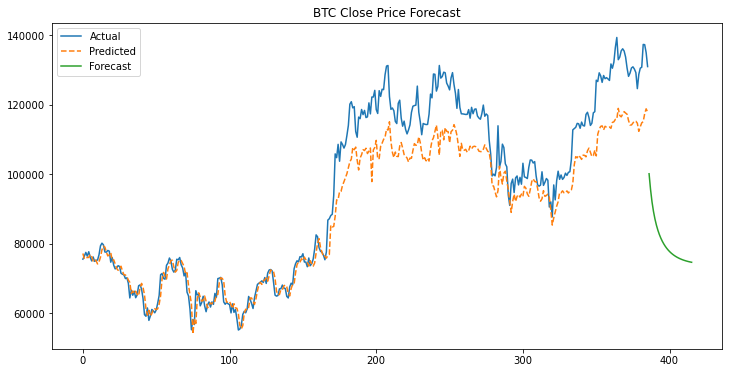

In [18]:
# Обратное масштабирование
scaler_robust = RobustScaler()
scaled_data = scaler_robust.fit_transform(df[features])

# Функции предсказания
def restore_scale(preds, scaler, n_features):
    return scaler.inverse_transform(np.array(preds).reshape(-1, n_features))

def batch_forecast(model, inputs, scaler, n_features):
    predictions = [model.forward(seq) for seq in inputs]
    return restore_scale(predictions, scaler, n_features)

def forecast_future(model, base_seq, scaler, n_future=30, n_features=3):
    output = []
    seq = base_seq.copy()
    for _ in range(n_future):
        next_point = model.forward(seq)
        output.append(next_point)
        seq = np.vstack([seq[1:], next_point.T])
    return restore_scale(output, scaler, n_features)

# Предсказание и визуализация
test_pred_scaled = batch_forecast(rnn, X_val, scaler_robust, input_dim)
last_seq = scaled_data[-window:]
forecast_result = forecast_future(rnn, last_seq, scaler_robust, forecast_days := 30, input_dim)

plt.figure(figsize=(12, 6))
plt.plot(scaler_robust.inverse_transform(y_val)[:, 0], label='Actual')
plt.plot(test_pred_scaled[:, 0], '--', label='Predicted')
plt.plot(range(len(y_val), len(y_val)+forecast_days), forecast_result[:, 0], label='Forecast')
plt.title('BTC Close Price Forecast')
plt.legend()
plt.show()


In [37]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd

def plot_training_loss(ax, loss_hist):
    ax.plot(loss_hist, color='blue')
    ax.set_title("Training Loss")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Loss")
    ax.grid(True, linestyle='--', alpha=0.5)

def plot_predicted_vs_real(ax, y_true, y_pred):
    scatter = ax.scatter(
        y_true[:, 0], y_pred[:, 0],
        alpha=0.5, c=np.abs(y_true[:, 0] - y_pred[:, 0]), cmap="viridis"
    )
    min_v = min(y_true[:, 0].min(), y_pred[:, 0].min())
    max_v = max(y_true[:, 0].max(), y_pred[:, 0].max())
    ax.plot([min_v, max_v], [min_v, max_v], "--r")
    ax.set_title("Predicted vs Real (Close)")
    ax.set_xlabel("Real")
    ax.set_ylabel("Predicted")
    plt.colorbar(scatter, ax=ax, label="Absolute Error")

def plot_error_distribution(ax, y_true, y_pred):
    errors = y_true[:, 0] - y_pred[:, 0]
    ax.hist(errors, bins=30, color="darkred", alpha=0.7)
    ax.set_title("Prediction Error Distribution")
    ax.set_xlabel("Error")
    ax.set_ylabel("Frequency")
    ax.grid(True, linestyle='--', alpha=0.5)

def plot_price_and_volatility(ax, df_raw):
    df = df_raw.copy()
    df["MA"] = df["Close"].rolling(window=7).mean()
    df["Vol"] = df["Close"].rolling(window=7).std()
    ax.plot(df["Close"], label="Close", alpha=0.6)
    ax.plot(df["MA"], label="7-day MA")
    ax.plot(df["Vol"], label="Volatility", color="green")
    ax.set_title("Close Price & Volatility")
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.5)

def plot_future_forecast(ax, future_dates, future_prices):
    future_prices = np.ravel(future_prices)
    future_dates = pd.to_datetime(future_dates)
    if len(future_prices) != len(future_dates):
        raise ValueError(f"Length mismatch: {len(future_prices)} prices vs {len(future_dates)} dates")
    ax.plot(future_dates.to_numpy(), future_prices, marker="o", color="orange")
    ax.set_title("Future Forecast")
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%d %b"))
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=5))
    plt.setp(ax.get_xticklabels(), rotation=45)
    ax.grid(True, linestyle='--', alpha=0.5)

def dashboard(model, loss_hist, val_data, forecast_data, df_raw, used_cols):
    y_true, y_pred = val_data
    future_prices, future_dates = forecast_data

    fig = plt.figure(figsize=(28, 20))
    fig.suptitle("RNN Analysis", fontsize=18)

    ax1 = plt.subplot2grid((4, 4), (0, 0), colspan=2)
    plot_training_loss(ax1, loss_hist)

    ax2 = plt.subplot2grid((4, 4), (0, 2))
    plot_predicted_vs_real(ax2, y_true, y_pred)

    ax3 = plt.subplot2grid((4, 4), (0, 3))
    plot_error_distribution(ax3, y_true, y_pred)

    ax4 = plt.subplot2grid((4, 4), (1, 0), colspan=2)
    plot_price_and_volatility(ax4, df_raw)

    ax5 = plt.subplot2grid((4, 4), (2, 2), colspan=2)
    plot_future_forecast(ax5, future_dates, future_prices)

    plt.tight_layout(rect=[0, 0, 1, 0.94])
    plt.show()


/tmp/ipykernel_18821/2023565374.py:24: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar(scatter, ax=ax, label="Absolute Error")


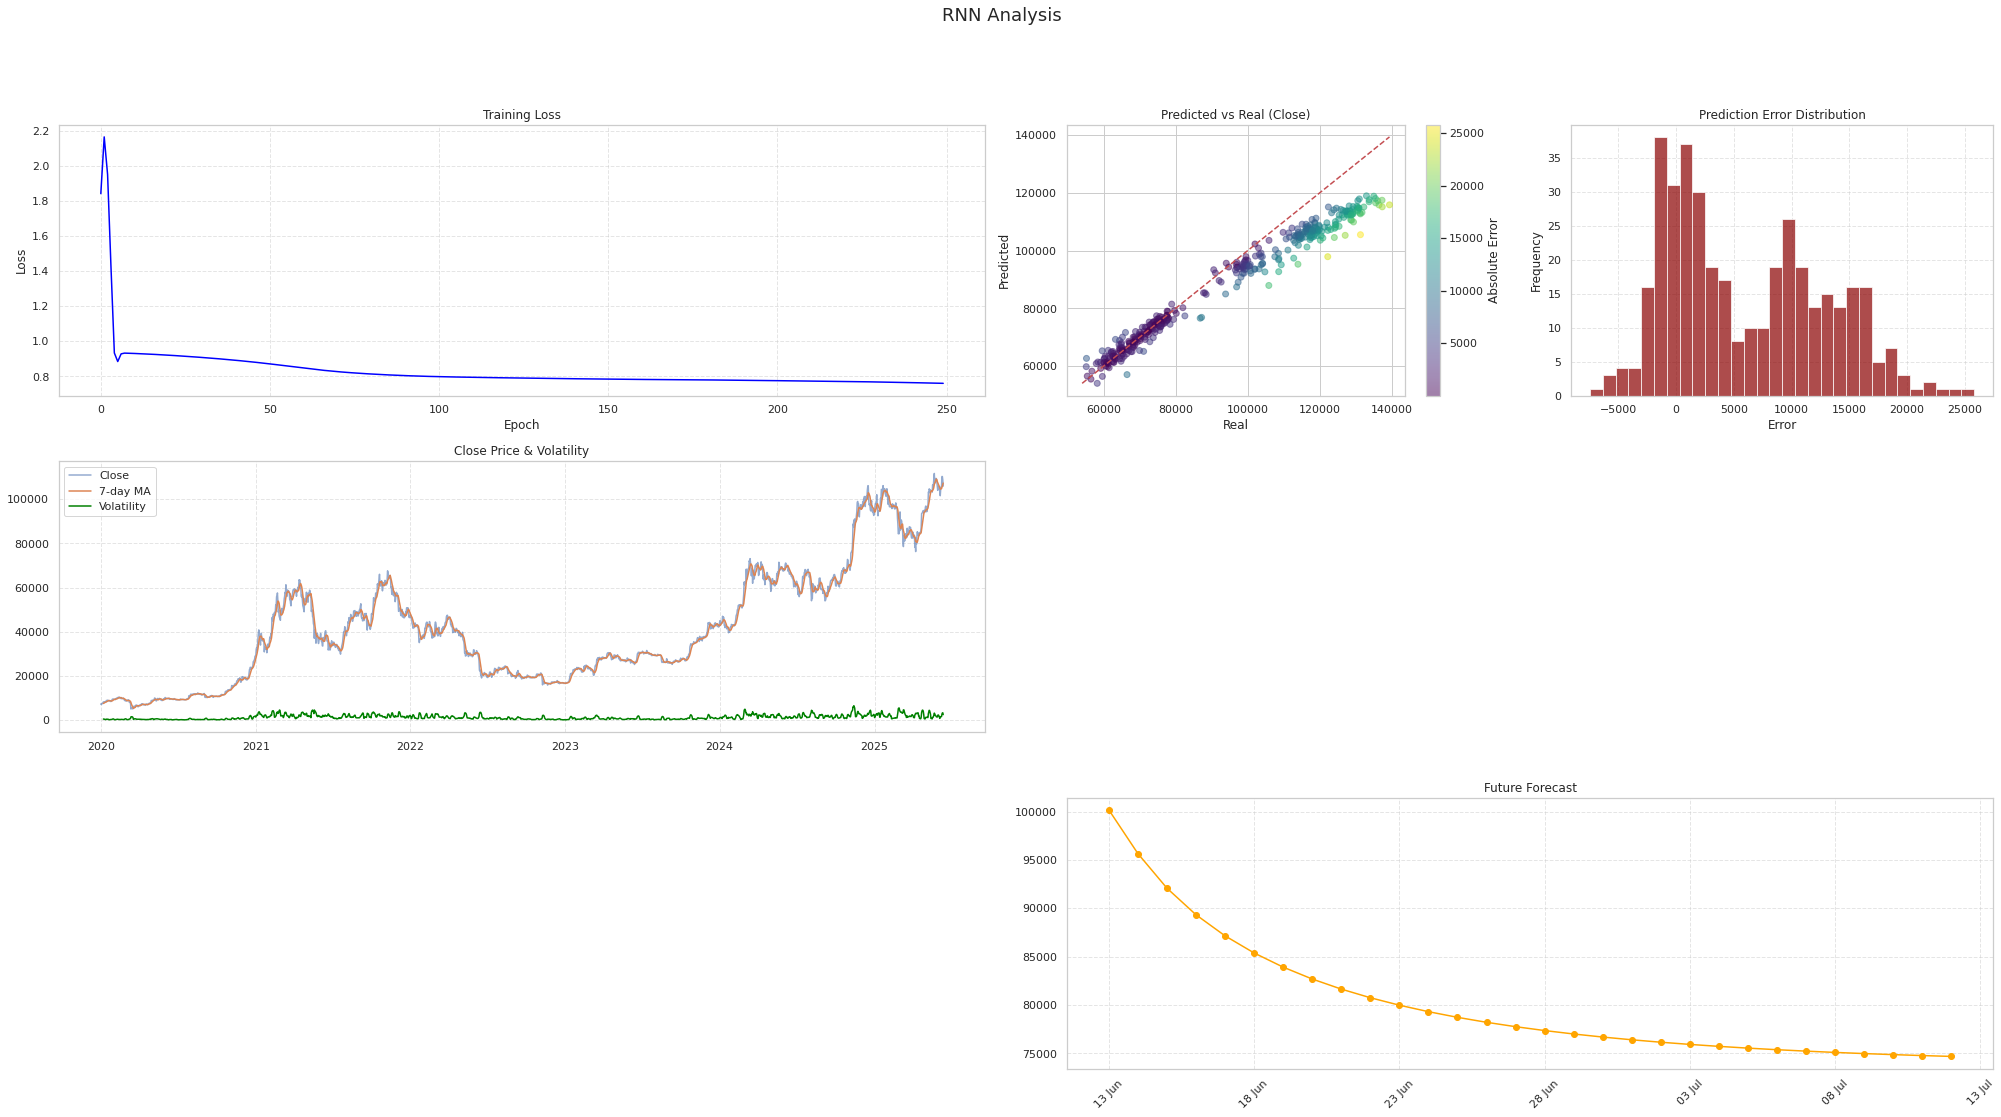

In [38]:
forecast_vals = np.ravel(forecast_result[:, 0])  # или просто .reshape(-1)
forecast_idx = pd.date_range(df.index[-1] + pd.Timedelta(days=1), periods=forecast_days)

dashboard(
    model=rnn,
    loss_hist=history,
    val_data=(y_val_inv, pred_inv),
    forecast_data=(forecast_vals, forecast_idx),
    df_raw=df.copy(),
    used_cols=features
)

В процессе работы над прогнозом удалось выявить несколько факторов, которые могли негативно сказываться на его качестве:

Недостаточное количество эпох обучения. Изначально модель обучалась всего 20 эпох, что явно недостаточно. После увеличения числа эпох до 150 и затем до 250 наблюдалось заметное снижение ошибки и улучшение предсказаний.

Тип нормализации данных. Использование StandardScaler() давало менее стабильные результаты. После перехода на RobustScaler(), который устойчив к выбросам, модель стала работать стабильнее.

Слишком узкий набор признаков. Модель, основанная только на одном признаке Close, показывала слабые результаты. Добавление Open и Volume помогло улучшить качество прогнозов.

Метод оптимизации. Проводились эксперименты с различными подходами к обучению. В частности, был протестирован оптимизатор Adam, но существенных улучшений он не дал — возможно, из-за простой архитектуры модели.

Архитектура модели. Пробовались различные модификации, включая добавление dropout, однако значимого прироста качества это не дало. Похоже, для серьёзных улучшений стоит рассматривать кардинально иные архитектурные подходы.

